In [2]:
%matplotlib inline
import swarced as sw
from astropy.io import ascii
import random, os, pickle, bls, time
import numpy as np
import matplotlib.pyplot as pl
import remove_EB as remEB
from IPython.display import clear_output
import multiprocessing as mp

In [114]:
def blswrap(epicid, campaign=0, initial_time=0):
    start = time.time()
    t, f = sw.retrieve(epicid, campaign)
    if initial_time != 0:
        t, f = t[t>initial_time], f[t>initial_time]
    u, v = np.zeros(len(t)), np.zeros(len(f))
    minfreq, dfreq, nfreq = 0.015, 2.0437359493152146e-05,100000
    nbin = 10
    minduration, maxduration = 0.01, 0.05
    results = bls.eebls(t, f, u, v, nfreq, minfreq, dfreq, 10, minduration, maxduration)
    end = time.time()
    return epicid, results

#Campaign 0 Comparison 

In [118]:
CAMPAIGN = 0
all_lc_list = ascii.read("/k2_data/all_c0_lcs")
ref = ascii.read("/k2_data/c0_EB")
all_lc_epic = [int(lc.split("/")[-1][4:13]) for lc in all_lc_list['filenames'] if ".fits" in lc]

In [119]:
samplesize = 150
all_lc_epic = np.array(all_lc_epic)
mask = np.array([epic not in ref['KIC/EPIC'] for epic in all_lc_epic])
sample = random.sample(all_lc_epic[mask], samplesize) + random.sample(ref['KIC/EPIC'], samplesize)
while len(set(sample)) != samplesize*2:
    sample = random.sample(all_lc_epic, samplesize/2) + random.sample(ref['KIC/EPIC'], samplesize)

In [120]:
start = time.time()
pool = mp.Pool(processes=mp.cpu_count())
results = pool.map(blswrap, sample)
pool.close()
pool.join()
end = time.time()
#results = np.array(results)

In [122]:
refmask = np.array([r[0] in ref['KIC/EPIC'] for r in results])

In [123]:
resultsdata = np.array([r[1] for r in results])

In [124]:
refdata = np.array([ref['period'][np.argmax(ref['KIC/EPIC']==r[0])] for r in results if r[0] in ref['KIC/EPIC']])

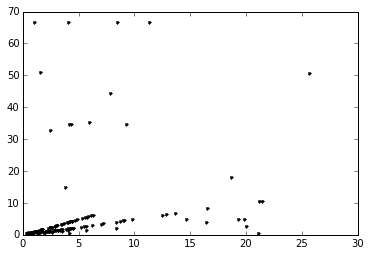

In [24]:
pl.plot(refdata,resultsdata[refmask][:,1],'k.')
#pl.ylim(0,20)
#pl.xlim(0,20)

(0, 20)

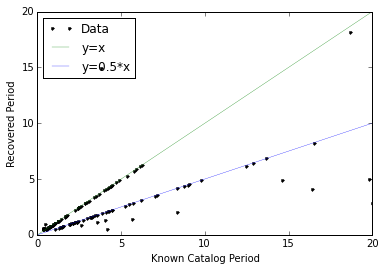

In [142]:
pl.plot(refdata,resultsdata[refmask][:,1],'k.',label="Data")
pl.xlabel("Known Catalog Period")
pl.ylabel("Recovered Period")
pl.plot(np.linspace(0,20,10),np.linspace(0,20,10),'g',label="y=x",lw=0.3)
pl.plot(np.linspace(0,20,10),np.linspace(0,20,10)*0.5,'b',label="y=0.5*x",lw=0.3)
pl.legend(loc=2)
#pl.legend(bbox_to_anchor=(1, 1))
pl.ylim(0,20)
pl.xlim(0,20)

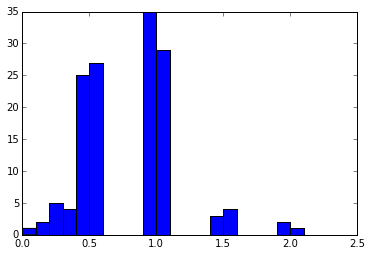

In [26]:
pl.hist(resultsdata[refmask][:,1]/refdata,np.arange(0,2.5,0.1))
pl.show()

In [27]:
ss = np.array(resultsdata[refmask][:,1]/refdata)

In [28]:
success = ((ss > 0.99) * (ss < 1.11)) | ((ss > 0.49) * (ss < 0.51))

Here you can see the comparison of recovered periods for the non-EBs (top) and the EBs (bottom). So things with high recovered periods, expecially around 70 or 35 (since 70 days is the limit and 35 is the half-limit) are likely false detections.

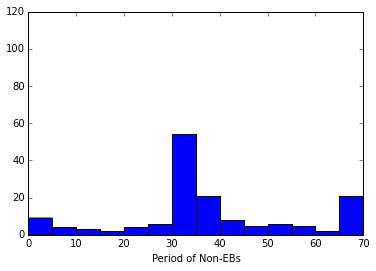

In [47]:
pl.hist(resultsdata[:,1][np.logical_not(refmask)],np.arange(0,75,5))
pl.ylim(0,120)
pl.xlabel("Period of Non-EBs")
pl.show()

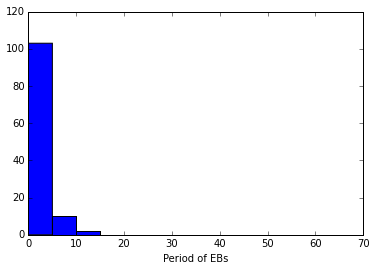

In [49]:
pl.hist(resultsdata[:,1][refmask][success],np.arange(0,75,5))
pl.ylim(0,120)
pl.xlabel("Period of EBs")
pl.show()
#One note about this graphic is that it lies some... long period EBs weren't recovered as much and thus are excluded by success

Now we can compare the power of the best power (the power associated with the best period)

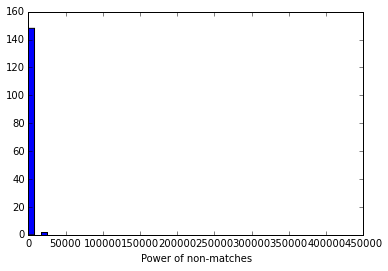

In [59]:
pl.hist(resultsdata[:,2][np.logical_not(refmask)], np.linspace(0,400000,50))
pl.xlabel("Power of non-matches")
pl.show()

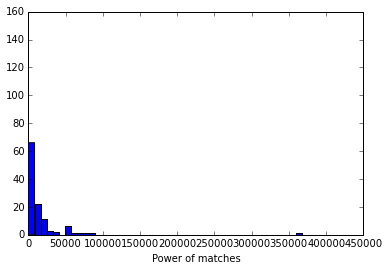

In [60]:
pl.hist(resultsdata[refmask][success][:,2], np.linspace(0,400000,50))
pl.xlabel("Power of matches")
pl.ylim(0,160)
pl.show()

As you can see the power of matches tends to be higher, but that left most column is the trouble column. 

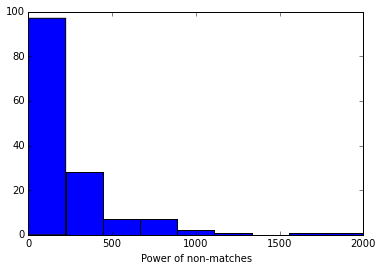

In [68]:
pl.hist(resultsdata[:,2][np.logical_not(refmask)], np.linspace(0,2000,10))
pl.xlabel("Power of non-matches")
pl.show()

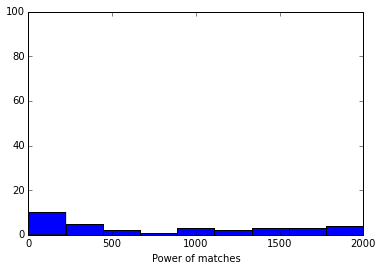

In [69]:
pl.hist(resultsdata[refmask][success][:,2], np.linspace(0,2000,10))
pl.xlabel("Power of matches")
pl.ylim(0,100)
pl.show()

You could use this as a criteria and cut off most of the non-EBs at about 500 but you could be losing a dozen or so EBs as well.

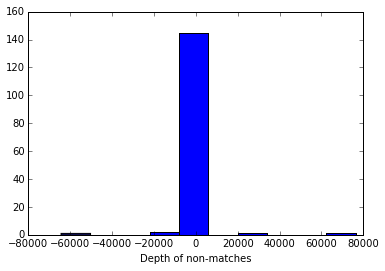

In [74]:
pl.hist(resultsdata[:,3][np.logical_not(refmask)])
pl.xlabel("Depth of non-matches")
pl.show()

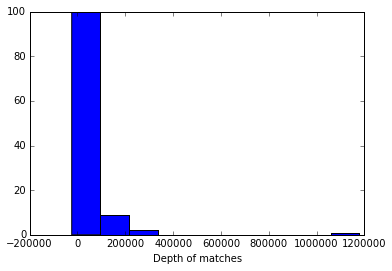

In [75]:
pl.hist(resultsdata[refmask][success][:,3])
pl.xlabel("Depth of matches")
pl.ylim(0,100)
pl.show()

In [80]:
sum(resultsdata[refmask][success][:,3]<0)

5

If the recovered depth is less than zero, only about 5 times in 150 for real EBs, you can safely say it's not an EB.

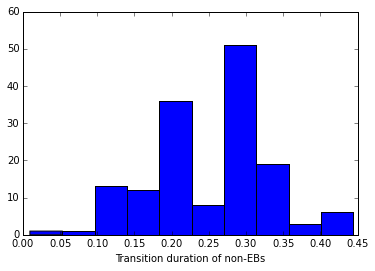

In [87]:
pl.hist(resultsdata[:,4][np.logical_not(refmask)])
pl.xlabel("Transition duration of non-EBs")
pl.show()

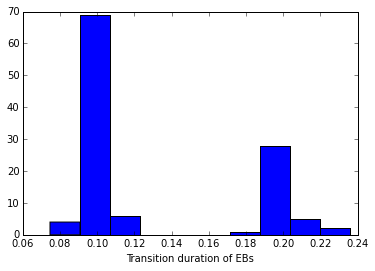

In [88]:
pl.hist(resultsdata[refmask][success][:,4])
pl.xlabel("Transition duration of EBs")
pl.show()

I don't think we can safely use transition duration becasue I would imagine there could be longer EBs.

#Campaign 2 

In [143]:
CAMPAIGN = 2
all_lc_list = ascii.read("/k2_data/all_c2_lcs")
all_lc_epic = [int(lc.split("/")[-1][4:13]) for lc in all_lc_list['filenames'] if ".fits" in lc]

In [144]:
samplesize = 1000
sample = random.sample(all_lc_epic, samplesize)

In [145]:
def blswrapc2(epicid):
    return blswrap(epicid, campaign=2,initial_time=2.45689e6+10.)

In [146]:
start = time.time()
pool = mp.Pool(processes=mp.cpu_count())
results = pool.map(blswrapc2, sample)
pool.close()
pool.join()
end = time.time()
#results = np.array(results)

In [147]:
resultsdata = np.array([r[1] for r in results])

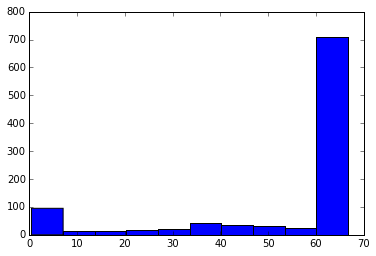

In [148]:
pl.hist(resultsdata[:,1])
pl.show()

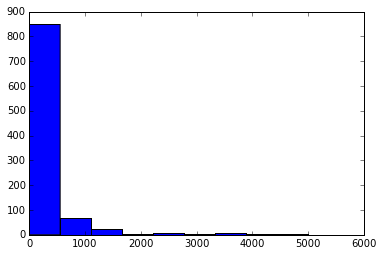

In [149]:
pl.hist(resultsdata[:,2],np.linspace(0,5000,10))
pl.show()

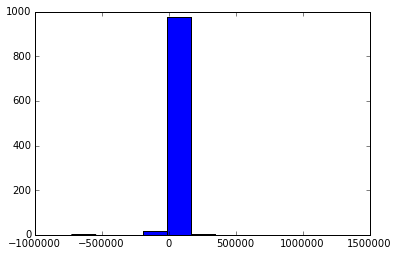

In [150]:
pl.hist(resultsdata[:,3])
pl.show()

In [151]:
def is_EB(result):
    return (result[1][3] > 0) * (result[1][2] > 500) * (result[1][1]<30)

In [157]:
examined = []
confirms = []
campaign = 2

In [155]:
reload(sw)

<module 'swarced' from 'swarced.py'>

In [158]:
for candidate in results:
    if candidate[0] not in examined:
        if is_EB(candidate):
        #if candidate[1][3] > 0 and candidate[1][2] > 2000:
            fig = sw.plot_lc(candidate[0],campaign,ylimtype='minmax',xlim = [2.45689e6+10.,2.45689e6+80])
            sw.plot_phase(candidate[0],campaign,candidate[1][1],0,initial_time=2.45689e6+10.)
            sw.plot_phase(candidate[0],campaign,candidate[1][1]*2,0,initial_time=2.45689e6+10.)
            pl.show()
            var = raw_input("Vote Y or N: ")
            if var == "Y" or var=="y":
                confirms += [candidate[0]]
            if var == "B" or var=='b':
                break
            clear_output()
        examined.append(candidate[0])

In [159]:
confirms

[205050711, 204275121, 205728486, 202844711, 205200600]

In [166]:
resultsepic = np.array([r[0] for r in results])

In [167]:
np.argmax(resultsepic==205050711)

278

In [169]:
results[278]

(205050711,
 (array([ 889.66115018,  831.3255504 ,  737.12405853, ...,  185.66103719,
          192.91436414,  192.97686111]),
  4.297779085547411,
  3070.45678126279,
  10486.948119267196,
  0.09469153515064563,
  9,
  9))